In [40]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from numba import jit

### Introdução
A atividade a ser explorada neste trabalho diz respeito ao processo de termalização. Aqui será apresentada uma simulação do modelo de Ising 2D com base no algoritmo de Metropolis. 
O modelo de Ising 2D pode ser entendido como um grid de pontos, no qual cada ponto representa um spin, isto é, um momento magnético. Cada spin pode assumir dois valores: +1 ou -1. O modelo de Ising 2D é um modelo de mecânica estatística que descreve a interação entre spins vizinhos.

In [41]:
@jit
def initial_system_config(N):
    """
    Define a configuração inicial do sistema aleatoriamente 
    S é um array unidimensional que recebe valores aleatórios -1 ou 1 em cada uma de suas posições
    """
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

Para fins de otimização, optou-se por representar o grid do modelo de ising como um array unidemensional. Para isso, foi necessário criar uma função que mapeia a posição de um spin no grid para a posição correspondente no array. Essa função é apresentada abaixo.

In [42]:
@jit(nopython=True)
def vizinhos(N):
    """
    Define a tabela de vizinhos
    """
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

Seguindo com otimizações, aqui temos uma função que define um vetor de 5 posições de acordo com as possibilidades de valor para a diferença de energia entre dois estados. Essa função é utilizada para evitar o cálculo da exponencial de um número muito grande e muitas vezes, armazenanado os valores possíveis em um vetor e acessando-os quando necessário.

In [43]:
@jit
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

Em seguida é a presentada a função que calcula a energia do sistema, a qual é utilizada para calcular a energia do sistema antes e depois de uma mudança de spin(flip). A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Aprofundaremos esses conceitos mais adiante.

In [44]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

Aqui temos o algoritmo de Metropolis, que é utilizado para simular o modelo de Ising 2D. O algoritmo consiste em um loop que itera sobre cada spin do grid. Para cada spin, é calculada a energia do sistema antes e depois de um flip. A diferença entre esses dois valores é utilizada para calcular a probabilidade de aceitação da mudança de spin. Caso a probabilidade de aceitação seja maior que um número aleatório entre 0 e 1, o flip é aceito. Caso contrário, o flip é rejeitado. Esse processo é repetido até que o sistema atinja o equilíbrio.

In [45]:
@jit
def metroplis_ising(N, T, mc_steps):    
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    magnetizations = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))   
        magnetizations.append(np.sum(S)) 
    
    return energy_system, magnetizations

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

Abaixo encontram-se as funções que manejam o algoritmo de Metropolis. Elas recebem como parâmetros o estado inicial do sistema, o número de iterações (passos de Monte Carlo) e a temperatura. Ela retorna o número de spins, temperatura, energia e magnetização definidos para o sistema a partir da chamada de metropolis_ising. Os dois últimos encontram-se em listas, nas quais cada uma das posições dizem respeito ao estado do sistema após um passo de monte carlo.

Aqui optou-se por permitir ao usuário que escolha entre a configuração padrão - definida pelo enunciado da atividade - ou uma configuração aleatória. O controlador disso é o parâmetro standard, que por padrão é True, definindo 1024 spins e temperatura = 1.5. Caso o usuário queira uma configuração aleatória, basta passar o parâmetro como False e então serão gerados N e T em um intervalo definido T = [0.4, 3] real  e N = [20, 100] inteiro.

In [46]:
def generate_systems(N=1024, T=1.5, n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas A partir de valores definidos de Número de spins(N) e Temperatura (T). \n
    O caso de padrão tem temperatura é fixa em 1.5 e o tamanho de cada sistema em 1024 spins.
    """
    energies = []
    magnetizations = []

    for _ in range(n_systems):
        ener, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(ener)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [47]:
def generate_random_systems(L_range=[24,100], T_range=[0.4, 3], n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios \n
    No caso de aleatórios a temperatura e o tamanho do sistema são gerados aleatoriamente
    dentro dos intervalos definidos por T_range e N_range, respectivamente, que são listas de dois valores.
    """
    energies = []
    magnetizations = []
    
    T = np.random.uniform(T_range[0], T_range[1])
    N = np.random.randint(L_range[0], L_range[1]) ** 2

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

In [48]:
def specific_heat(N=1024, T=1.5, energies=None, mc_steps=1000):
    """
    Calculates the specific heat of the system
    """
    if energies is None:
        energies, _, _, _ = generate_systems(N, T, 1, mc_steps)
    
    energies = np.array(energies)
    energy_mean = np.mean(energies)
    energy_mean2 = np.mean(energies**2)
    
    specific_heat = (energy_mean2 - energy_mean**2) * ((1/T**2) / N)

    return specific_heat

In [49]:
def magnetic_susceptibility(N=1024, T=1.5, magnetizations=None, mc_steps=1000):
    """
    Calculates the magnetic susceptibility of the system
    """
    if magnetizations is None:
        _, magnetizations, _, _ = generate_systems(N, T, 1, mc_steps)
    
    magnetizations = np.array(magnetizations)
    magnetizations = np.absolute(magnetizations)
    magnetization_mean = np.mean(magnetizations)
    magnetization_mean2 = np.mean(magnetizations**2)
    
    magnetic_susceptibility = (magnetization_mean2 - magnetization_mean**2) * ((1/T) / N)

    return magnetic_susceptibility

In [50]:
def energyPerSpin(energyList, size):
    energyPerSpin = np.mean(energyList)/(size*size)
    return energyPerSpin

In [51]:
def magnetizationPerSpin(magnetizationList, size):
    magnetizationPerSpin = np.mean(magnetizationList)/(size*size)
    return magnetizationPerSpin

In [52]:
def calc_error(mean_value, boxes):
    """
    Calculates the statistical error of the values
    """
    return np.sqrt(np.sum((np.repeat(mean_value, len(boxes)) - boxes)**2) / len(boxes) * (len(boxes) - 1))

In [53]:
cd = np.arange(0, 10)
cd = np.array_split(cd, 5)
cd

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8, 9])]

In [54]:
def statistical_error_boxes_method(n_blocks, values_list, physical_atribute, N, T, mc_steps=1000):
  boxes = np.array_split(values_list[0], n_blocks)
  # values_estimate = [np.mean(box) for box in boxes]

  if physical_atribute == 'sh':
      sh = []
      sh = [specific_heat(N, T, value, mc_steps) for value in boxes]
      sh_mean = np.mean(sh)
      return calc_error(sh_mean, sh)
    
  elif physical_atribute == 'ms':
    ms = []
    ms = [magnetic_susceptibility(N, T, value, mc_steps) for value in boxes]
    ms_mean = np.mean(ms)
    return calc_error(ms_mean, ms)

In [55]:
def main(N=400, mc_steps=100_000):
    temperatures = np.linspace(0.5, 5.0, 100)
    cvList = []
    chiList = []
    cvErrorList = []
    chiErrorList = []
    energy = []
    magnetization = []

    for temp in temperatures:
        energies, magnetizations, _, _ = generate_systems(N=N, T=temp, n_systems=1, mc_steps=mc_steps)
        # specificHeat, susceptibility, specificHeatError, susceptibilityError = calculateSpecificHeatAndSusceptibility(energyList, magnetizationList, temp)
        cvList.append(specific_heat(N=N, T=temp, energies=energies))
        chiList.append(magnetic_susceptibility(N=N, T=temp, magnetizations=magnetizations))
        cvErrorList.append(statistical_error_boxes_method(100, energies, 'sh', N, temp, mc_steps))
        a = statistical_error_boxes_method(100, magnetizations, 'ms', N, temp, mc_steps)
        chiErrorList.append(a)
        energy.append(energyPerSpin(energies, N))
        magnetization.append(magnetizationPerSpin(magnetizations, N))
    
    return temperatures, cvList, chiList, cvErrorList, chiErrorList, energy, magnetization

In [56]:
temperatures, cvList, chiList, cvErrorList, chiErrorList, energy, magnetization = main()

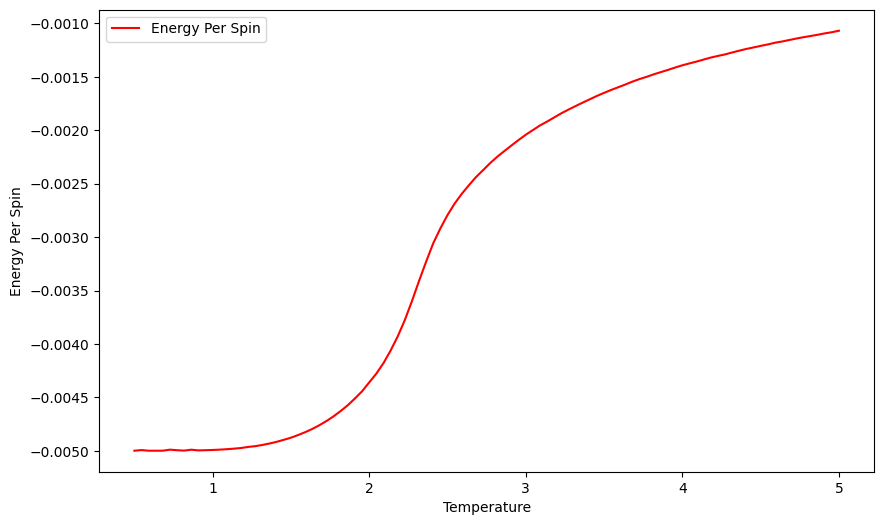

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, energy, color='red', label='Energy Per Spin')
plt.xlabel('Temperature')
plt.ylabel('Energy Per Spin')
plt.legend()
plt.show()

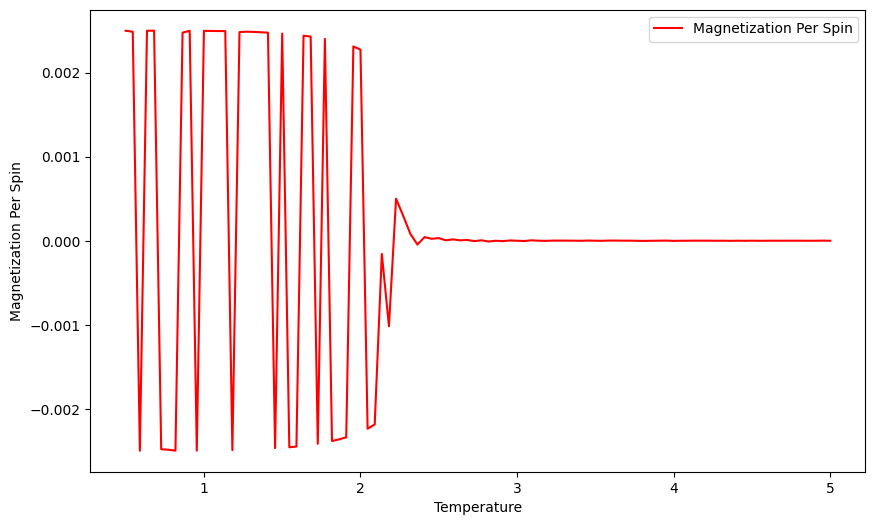

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, magnetization, color='red', label='Magnetization Per Spin')
plt.xlabel('Temperature')
plt.ylabel('Magnetization Per Spin')
plt.legend()
plt.show()

[3.2682100249135084, 32.48243647647668, 3.2678948108614754, 2.642412958077952, 1.1994295240451196, 10.573219255363744, 18.11910285421357, 1.8810806890046754, 1.8729823255218845, 1.2230101713850325, 1.5404389220271961, 1.005535573020415, 0.8668967769894842, 0.8867971958735208, 0.91312460438081, 0.9041683276135013, 4.879064296483287, 0.9665915539079659, 0.6472025037592503, 0.9659846903948179, 0.6063892492921508, 2.4596984919961424, 0.4792933546249879, 0.7744602110276697, 0.7846551001461521, 1.1181976376875347, 0.3247974372521493, 0.6309603467301991, 0.4857763739634308, 0.4447054608398579, 0.7412000954530089, 0.5739183183598413, 0.44119895546326954, 0.9306457982516554, 0.7133160380039495, 1.045934629217071, 1.1944282182334776, 1.4954527320075102, 1.9539732344484897, 1.5700488625961713, 1.433004256115161, 1.2191055106565263, 1.0658521042449067, 1.1274993363263999, 0.9994948081996292, 0.7871917934564999, 0.5465477351520923, 0.5081106833265423, 0.4264186164126852, 0.42067781317827097, 0.3135

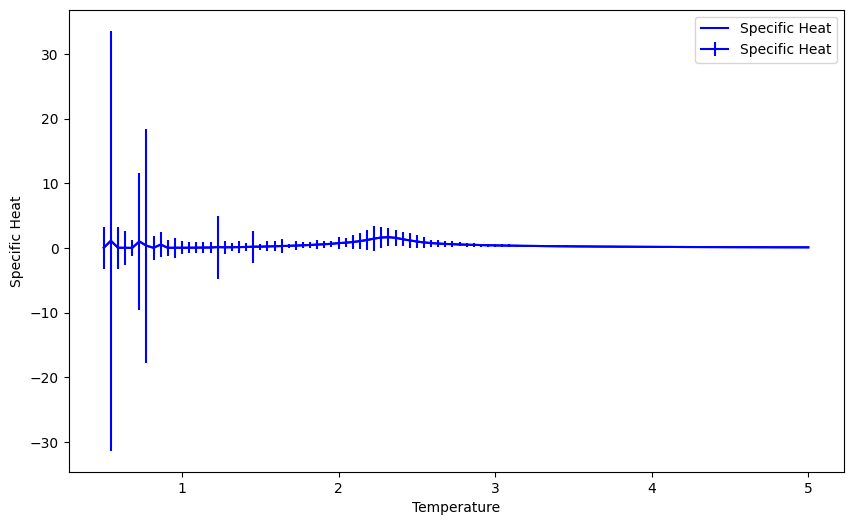

In [59]:
print(cvErrorList)
plt.figure(figsize=(10, 6))
plt.plot(temperatures, cvList, color='blue', label='Specific Heat')
plt.errorbar(temperatures, cvList, yerr=cvErrorList, color='blue', label='Specific Heat')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.legend()
plt.show()

[1.6629213891457841, 72.98203561773352, 1.8487635892081564, 1.0638580229716028, 0.3094927630873458, 27.602313255376362, 91.48254525218232, 1.6322320058222406, 14.473019444586209, 0.9062353087474181, 2.6547055019506414, 0.5522481036378735, 0.7941357706848717, 0.6959299575313839, 0.5713358782201563, 2.098129850634721, 49.17471001897029, 1.9691144005101067, 0.9419802308247646, 1.9580034557978878, 0.4103428749321561, 15.68178071383924, 1.083303492217542, 0.9480444101471551, 2.522173086720271, 5.7410186694663885, 0.18873336208945157, 0.8693404686612898, 0.6538932646257175, 0.7539177422358208, 2.1984157818534706, 1.3117007664992244, 0.6061202168619435, 5.6977814417907595, 1.7962858911770796, 3.7342038154959742, 6.953111019120639, 12.354869424967745, 19.21919751375152, 20.58947027161203, 18.358194174094344, 12.207934060250686, 6.78889889000633, 6.1198722666701855, 6.30869041069727, 5.369783897503129, 4.181569086156605, 3.9195464476435546, 3.194403896940635, 2.6838756774239965, 2.1669164265094

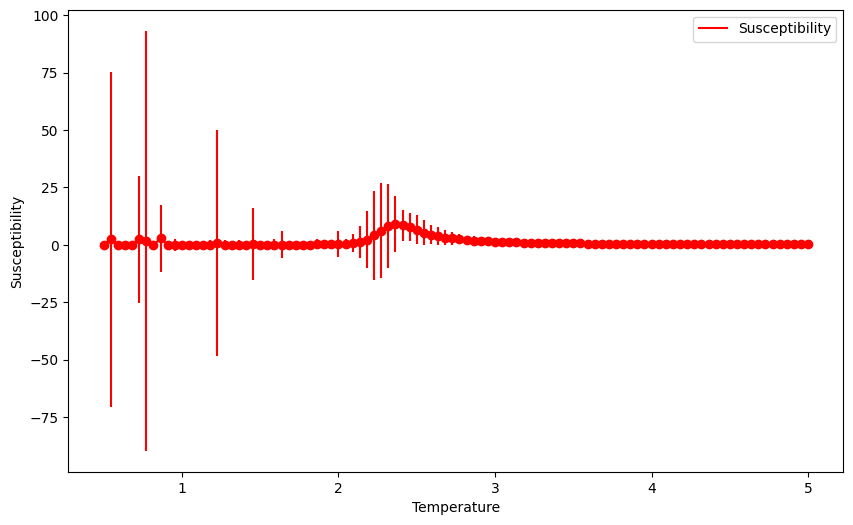

In [60]:
print(chiErrorList)
plt.figure(figsize=(10, 6))
plt.plot(temperatures, chiList, color='red', label='Susceptibility')
plt.errorbar(temperatures, chiList, yerr=chiErrorList, color='red', fmt ='o')
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.legend()
plt.show()